In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
import seaborn as sns
import statistics
import math
import pickle 
import os
import multiprocessing as mp
import argparse
import concurrent.futures
import matplotlib.colors as mcolors

### Define fitness and combined phenotype (1 D)

In [2]:
def w(z_combined):
    return (np.exp(-z_combined**2 /(100))) 

def z_dist(z1, env_opt):
    x0 = env_opt
    return ((np.sqrt((x0 - z1)**2 )))

In [ ]:
# Define rho and m grid
rho = np.linspace(-1, 1, 15)
m = np.linspace(0, 1, 15)

RHO, M = np.meshgrid(rho, m)

# Define ALPHA and BETA
ALPHA = (1 - RHO) * (1 - M)
BETA = (1 - RHO) * M

# Flatten and create DataFrame
data_env = np.column_stack((RHO.flatten(),
                        M.flatten(),
                        ALPHA.flatten(),
                        BETA.flatten()))

n_rows= len(RHO.flatten())
n_gen = 1000

Env = np.array([-8, 8])
states = np.zeros((n_rows, n_gen), dtype=int)

p = np.random.uniform(low=0, high=1, size=(n_rows, n_gen))
alpha = ALPHA.flatten()
beta =  ALPHA.flatten()


for g in range(1, n_gen):
    probs = np.where(states[:, g-1] == 0, alpha, 1 - beta)
    states[:, g] = (p[:, g] < probs).astype(int)

env_values = Env[states]  # final result
data_env= np.hstack([data_env, env_values])


# Mask where ALPHA > 1 or BETA > 1
mask = (data_env[:, 2] > 1) | (data_env[:, 3] > 1)

# Set ALPHA and BETA (columns 2 and 3) to NaN where mask is True
data_env[mask, 2:] = np.nan

clean_data_env = data_env[~np.isnan(data_env).any(axis=1)]

population_size= 1000
#env_df.loc[mask, env_df.columns[2:]] = np.nan
#clean_data_env = clpltean_data_env[40:140,:]
clean_data_env.shape

(151, 1004)

### Trial sim without parallelization : DONT RUN!!

In [ ]:
sigma_omega = 0.01
sigma_mut = 0.1
sigma_mat = 0.1


In [ ]:
gamma = 0.5
population_size = 1000


sigma_omega = 0.01
sigma_mut = 0.1
sigma_mat = 0.1
results_array = np.empty((len(clean_data_env), 7))

for i, row in enumerate(clean_data_env):
     
    param_data = row[:4]
    env_states = row[4:]
    
    epsilon_omega = np.random.normal(0, sigma_omega, (population_size, n_gen))
    epsilon_z = np.random.normal(0, sigma_mut, (population_size, n_gen))
    epsilon_mat= np.random.normal(0, sigma_mat, (population_size, n_gen))

     # Initialize base parameters
    omega_error  = np.clip((np.random.uniform(0, 1, population_size) + epsilon_z[:, 0]), 0,1)
    
    z_a_t = np.random.uniform(-0.1, 0.1, population_size)
    
    z_a_t_mut = z_a_t + epsilon_z[:, 0]
    #sample previous generations phenotypes

    
    P = np.random.uniform(-1, 1, population_size)
    delta_error= (gamma * (P - z_a_t)) + epsilon_mat[:, 0]

    
    #update P
    P = (1 - omega_error) * z_a_t_mut + omega_error * delta_error
    
    
    # sample large matrises of mutations and error effects
    # Main simulation loop
    for g in range(1,len(env_states+1)):
            optima = env_states[g]
            # Environment transition

      # Compute fitness and relative fitness
            P_com = z_dist(P, optima)
            fitness = w(P_com)
            relative_fitness = fitness / np.mean(fitness)
    
            # Fitness-proportional sampling via NumPy
            # Equivalent to df.sample(..., weights=..., replace=True)
            probs = relative_fitness / np.sum(relative_fitness)
            idx = np.random.choice(population_size, size=population_size, p=probs)
    
            # Resample population
            z_a_t_mut = z_a_t_mut[idx]
            P = P[idx]
            omega_error = omega_error[idx]

    
             # Use pre-sampled noise values for generation g:
            noise_omega = epsilon_omega[:, g]
            noise_mut = epsilon_z[:, g]
            noise_mat = epsilon_mat[:, g]
            
            # Use these noise values instead of re-sampling:
            omega_error = np.clip(omega_error + noise_omega, 0, 1)
            z_a_t_mut += noise_mut
            delta_error = (gamma * (P - z_a_t_mut)) + noise_mat
             # Update phenotype P
            P = (1 - omega_error) * z_a_t_mut + omega_error * delta_error
      
    # Compute equilibrium stats
    equilibrium_mean_omega = np.mean(omega_error)
    equilibrium_std_omega = np.std(omega_error)
    P_com = z_dist(P, optima)
    fitness = w(P_com)
    final_fitness = mp.mean(fitness)
    
    results_array[i, 0] = param_data[0]  # rho
    results_array[i, 1] = param_data[1]  # m
    results_array[i, 2] = param_data[2]  # alpha
    results_array[i, 3] = param_data[3]  # beta
    results_array[i, 4] = equilibrium_mean_omega
    results_array[i, 5] = equilibrium_std_omega
    results_array[i, 6]  = final_fitness
    

In [ ]:
results_df = pd.DataFrame(results_array, columns=['rho', 'm', 'alpha', 'beta', 'omega', 'omega_stdev'])
results_df

,rho,m,alpha,beta,omega,omega_stdev
0,0.000000,0.0,1.000000,0.000000,0.611301,0.248409
1,0.142857,0.0,0.857143,0.000000,0.720962,0.163740
2,0.285714,0.0,0.714286,0.000000,0.379239,0.222657
3,0.428571,0.0,0.571429,0.000000,0.691851,0.162799
4,0.571429,0.0,0.428571,0.000000,0.718675,0.091905
...,...,...,...,...,...,...
146,0.428571,1.0,0.000000,0.571429,0.959748,0.033030
147,0.571429,1.0,0.000000,0.428571,0.114821,0.084985
148,0.714286,1.0,0.000000,0.285714,0.177871,0.085485
149,0.857143,1.0,0.000000,0.142857,0.946054,0.041197


###  Run from below again

In [ ]:

def run_simulation(args):
    row, gamma, population_size, n_gen, sigma_omega, sigma_mut, sigma_mat = args

    # Unpack parameters and environment sequence
    param_data = np.array(row[:4], dtype=float)
    env_states = np.array(row[4:], dtype=float)

    n_env = len(env_states)

    # Pre-generate random noise matrices (avoid inside-loop calls)
    epsilon_omega = np.random.normal(0, sigma_omega, (population_size, n_env))
    epsilon_z     = np.random.normal(0, sigma_mut,  (population_size, n_env))
    epsilon_mat   = np.random.normal(0, sigma_mat,  (population_size, n_env))

    # Initial population states
    omega_error = np.clip(np.random.uniform(0, 1, population_size) + epsilon_z[:, 0], 0, 1)
    z_a_t       = np.random.uniform(-0.1, 0.1, population_size)
    z_a_t_mut   = z_a_t + epsilon_z[:, 0]
    P           = np.random.uniform(-1, 1, population_size)
    delta_error = gamma * (P - z_a_t) + epsilon_mat[:, 0]
    P           = (1 - omega_error) * z_a_t_mut + omega_error * delta_error
   
    # Iterate through environments (generations)
    for g in range(1, n_env):
        optima = env_states[g - 1]

        # Fitness computation (assumed vectorized)
        P_com = z_dist(P, optima)
        fitness = w(P_com)
        relative_fitness = fitness / np.mean(fitness)

        # Fitness-proportional resampling
        idx = np.random.choice(population_size, size=population_size, p=relative_fitness / np.sum(relative_fitness))
        z_a_t_mut = z_a_t_mut[idx]
        P = P[idx]
        omega_error = omega_error[idx]

        # Apply mutation noise
        omega_error = np.clip(omega_error + epsilon_omega[:, g], 0, 1)
        z_a_t_mut += epsilon_z[:, g]
        delta_error = gamma * (P - z_a_t_mut) + epsilon_mat[:, g]
        P = (1 - omega_error) * z_a_t_mut + omega_error * delta_error
        
    P_com = z_dist(P, optima)
    fitness = w(P_com)
    # Equilibrium stats
    return [
        param_data[0], param_data[1], param_data[2], param_data[3],
        gamma,
        np.mean(omega_error),
        np.std(omega_error),
        np.mean(fitness)
        
    ]


In [ ]:
 # Create all combinations of sigma_mut and sigma_alpha
sigma_alpha = 0.001
sigma_mut=0.1
sigma_mat=0.1
gamma_values = np.linspace(0, 1, 10)  # 0.0001 = 10^-4, 100 = 10^2




In [ ]:
if __name__ == '__main__':
    
    gamma_values = np.linspace(0, 1, 10)  # 0.0001 = 10^-4, 100 = 10^2
    #results_array = np.empty((len(clean_data_env), 7))
  
    sigma_alpha = 0.001
    sigma_mut=0.1
    sigma_mat=0.1
    
    # Create all combinations of sigma_mut and sigma_alpha
    param_grid = [
        (row, gamma, population_size, n_gen, sigma_omega, sigma_mut, sigma_mat)
        for _, row in enumerate(clean_data_env)
        for gamma in gamma_values
    ]

    num_cpus = 10
    
    with concurrent.futures.ProcessPoolExecutor(num_cpus) as executor: 
        results_array = list(executor.map(run_simulation, param_grid))


In [ ]:
# Convert all results into a DataFrame
results_df = pd.DataFrame(
        results_array,
        columns=['rho', 'm', 'alpha', 'beta', 'gamma', 'mean_omega', 'std_omega', 'fitness']
    )

In [ ]:
results_df.head()

,rho,m,alpha,beta,gamma,mean_omega,std_omega,fitness
0,0.0,0.0,1.0,0.0,0.000000,0.900207,0.065707,0.495900
1,0.0,0.0,1.0,0.0,0.111111,0.845708,0.108509,0.515386
2,0.0,0.0,1.0,0.0,0.222222,0.683763,0.137276,0.535145
3,0.0,0.0,1.0,0.0,0.333333,0.814924,0.117419,0.529807
4,0.0,0.0,1.0,0.0,0.444444,0.751711,0.128594,0.515622


In [ ]:
data_env_df = pd.DataFrame(data_env[:,:4] , columns=['rho', 'm', 'alpha', 'beta'])  
#select the full range of alphas and betas; with possibility to highlight imossible values


In [ ]:

df_merged = pd.merge(data_env_df, results_df, on=['rho', 'm', 'alpha', 'beta'], how='left')

if len(df_merged[~np.isnan(df_merged).any(axis=1)]) == 1510: #all non nan values of this table = results_df 
    print("All good!")

All good!


In [ ]:
df_merged.head()

,rho,m,alpha,beta,gamma,mean_omega,std_omega,fitness
0,-1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.857143,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.714286,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.571429,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.428571,0.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Valid Alphas and Betas

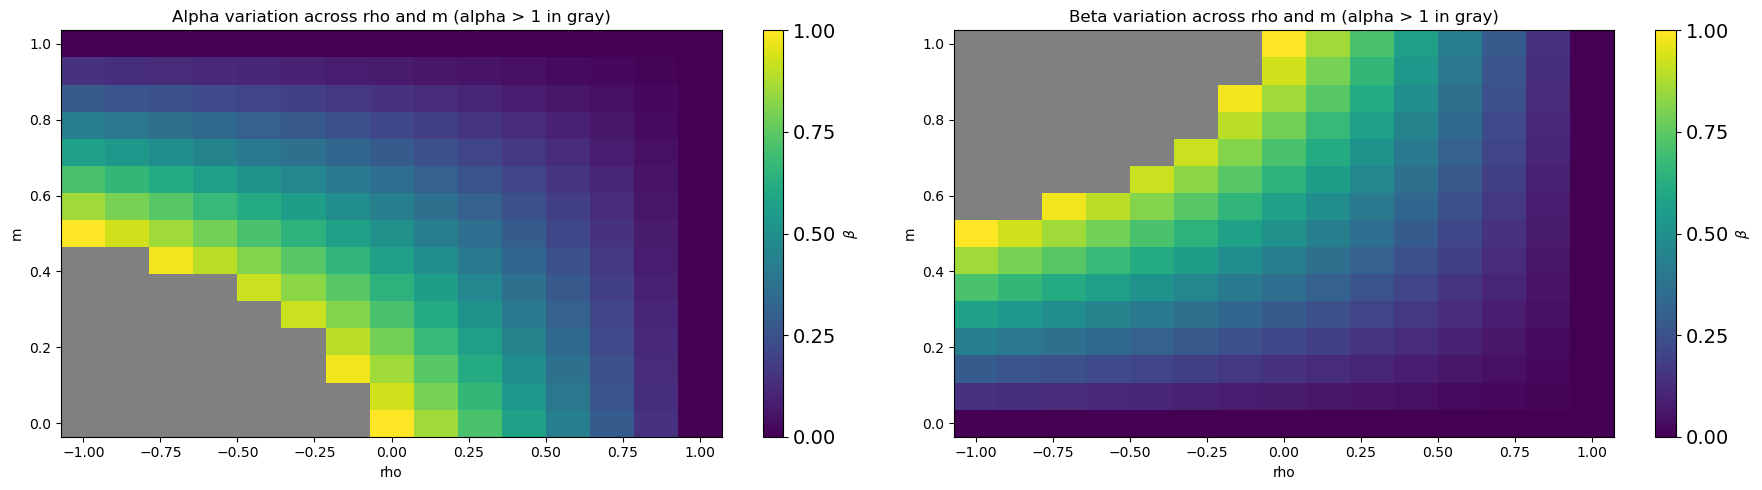

In [ ]:
# Meshgrid for plotting
RHO, M = np.meshgrid(pivoted_df.index, pivoted_df.columns)
#OMEGA = pivoted_df.values.T  # transpose for correct orientation

ALPHA = (1 - RHO) * (1 - M)    
BETA = (1 - RHO) * (M)
    
    # Mask values > 1
ALPHA_MASKED = np.ma.masked_greater(ALPHA, 1)
BETA_MASKED = np.ma.masked_greater(BETA, 1)

fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

    # Colormap and normalization
cmap = plt.cm.viridis.copy()  # make a copy so you can safely modify
cmap.set_bad(color='gray')    # gray for masked values
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # Force color scale to include 1
    

pcm = ax[0].pcolormesh(RHO, M, ALPHA_MASKED, cmap=cmap, norm=norm, shading='auto')
cbar = fig.colorbar(pcm, label=rf'$\beta$', ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
cbar.ax.tick_params(labelsize=14)
    
ax[0].set_xlabel('rho')
ax[0].set_ylabel('m')
ax[0].set_title('Alpha variation across rho and m (alpha > 1 in gray)')

pcm = ax[1].pcolormesh(RHO, M, BETA_MASKED, cmap=cmap, norm=norm, shading='auto')
cbar = fig.colorbar(pcm, label=rf'$\beta$', ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
cbar.ax.tick_params(labelsize=14)
    
ax[1].set_xlabel('rho')
ax[1].set_ylabel('m')
ax[1].set_title('Beta variation across rho and m (alpha > 1 in gray)')


plt.tight_layout()
plt.show()



#### Equilibrium epigenetic weight across gamma 

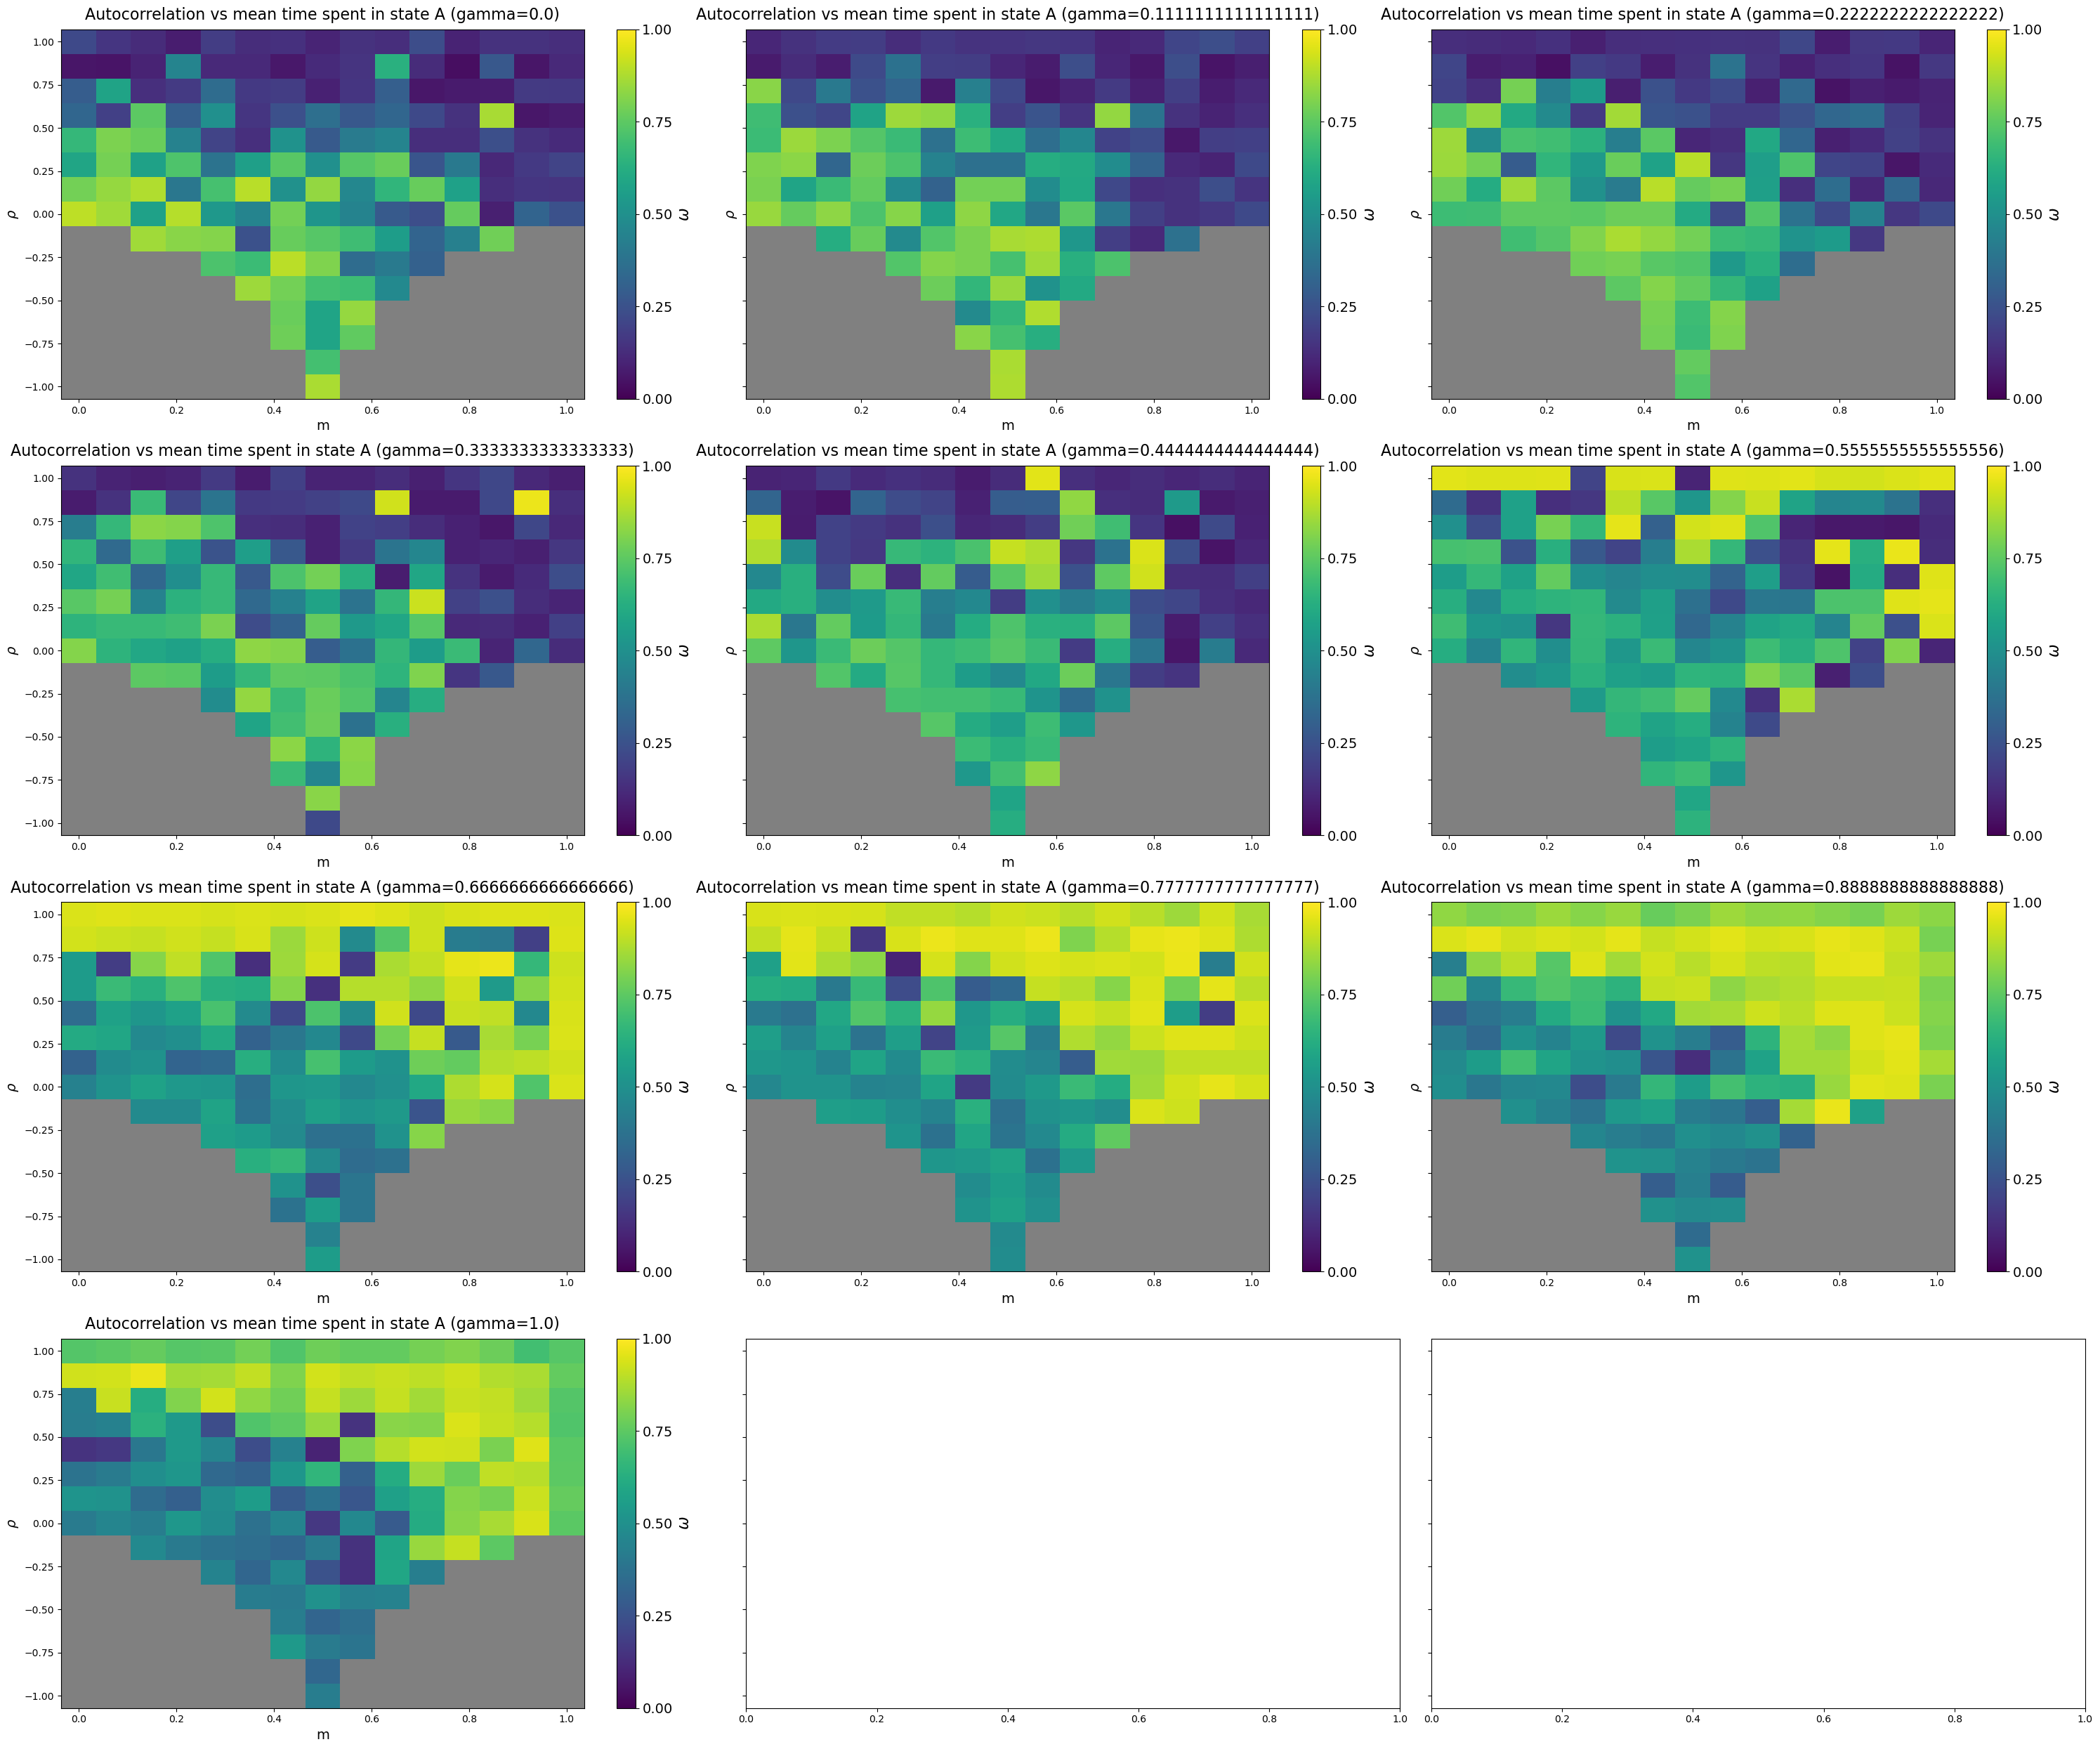

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize = (30,25),sharey=True)

# Flatten axes array for easy iteration
axes = axes.flat 

# Loop through each matching file and plot heatmap
for ax, (gamma_val, grp) in zip(axes, df_merged.groupby('gamma')):
  
    # Pivot table for this gamma
        pivoted_df = grp.pivot_table(
            index='rho',
            columns='m',
            values='mean_omega').sort_index().sort_index(axis=1)
        
        # Meshgrid for plotting
        RHO, M = np.meshgrid(pivoted_df.index, pivoted_df.columns)
        OMEGA = pivoted_df.values.T  # transpose for correct orientation
    
        cmap = plt.cm.viridis.copy()  # make a copy so you can safely modify
        cmap.set_bad(color='gray')    # gray for masked values
        norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # Force color scale to include 1
    
        
        contour =  ax.pcolormesh(M, RHO, OMEGA, cmap=cmap, norm=norm,)
        
    
        # Colorbar
        cbar = fig.colorbar(contour, ax=ax,ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label(r'$\omega$', size=16)
    
        # Labels and title
        ax.set_ylabel(r'$\rho$', fontsize=14)
        ax.set_xlabel('m', fontsize=14)
        ax.set_title(f'Autocorrelation vs mean time spent in state A (gamma={gamma_val})', fontsize=16, pad=10)


plt.tight_layout()
plt.show()

at higher gammas; either intermediate or high weight; especially athigh autocorrelation

In [ ]:
for ax, (gamma_val, grp) in zip(axes, df_merged.groupby('gamma')):
    print(ax)

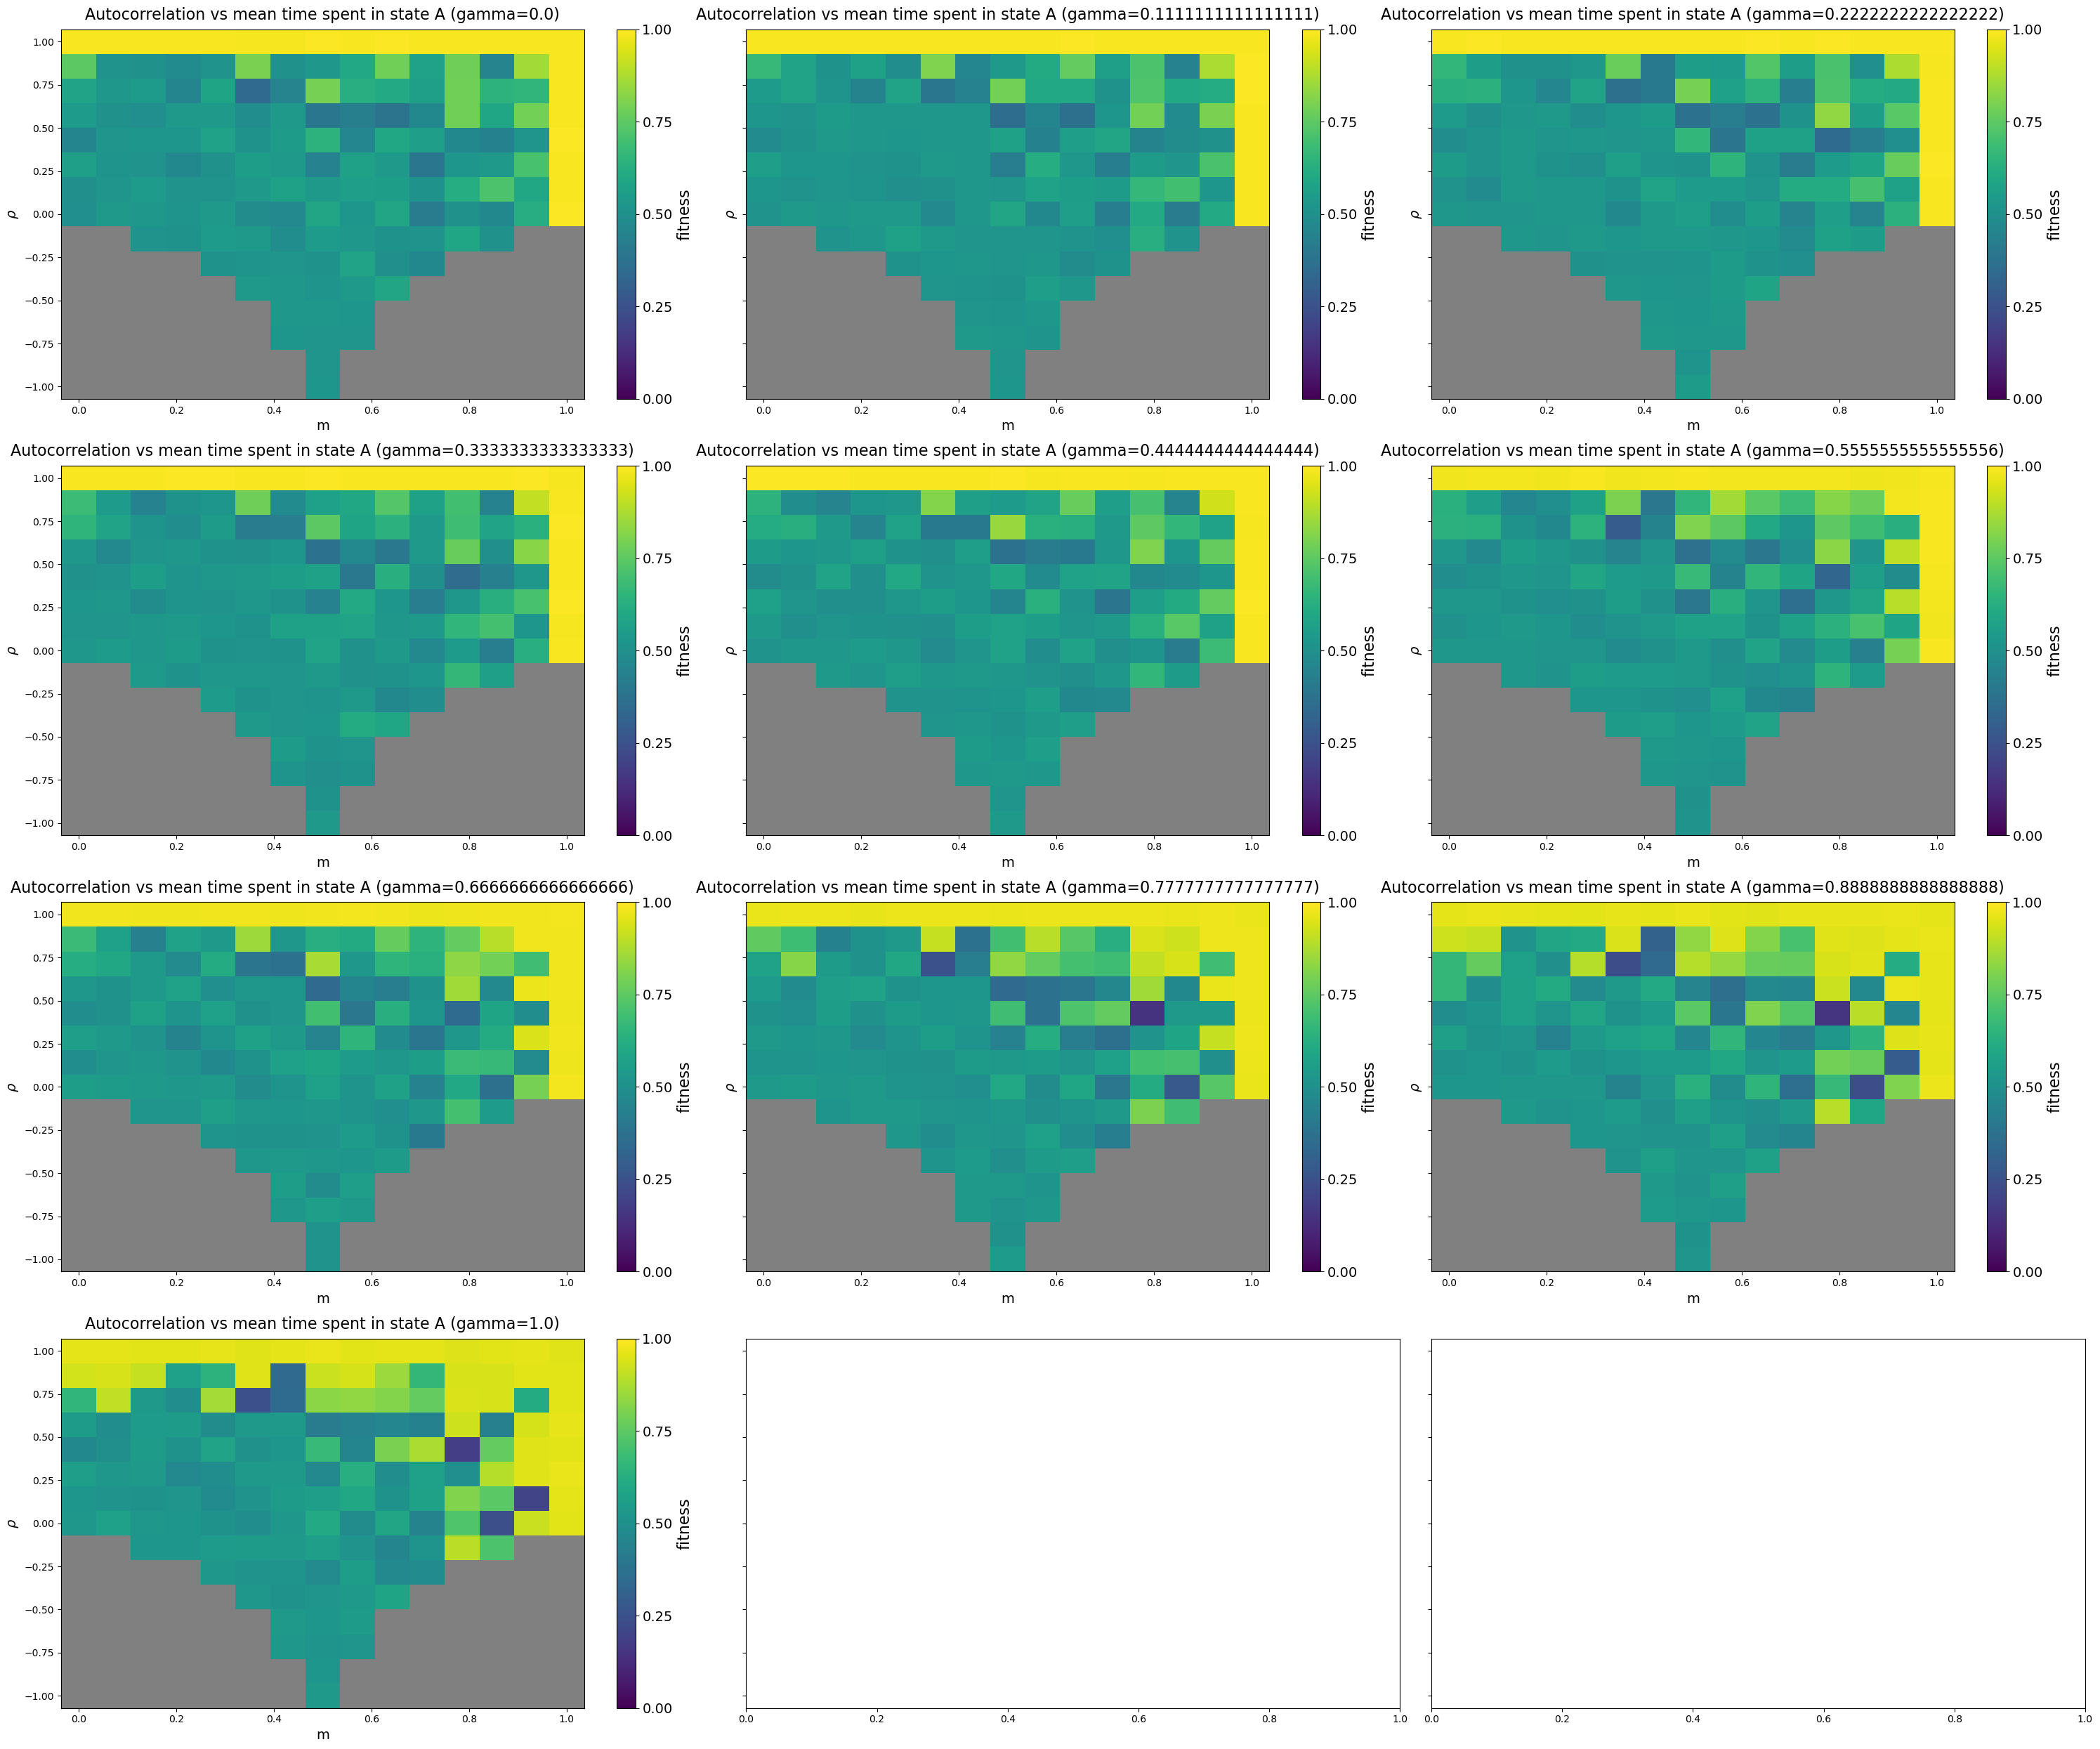

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize = (30,25),sharey=True)

# Flatten axes array for easy iteration
axes = axes.flat 

# Loop through each matching file and plot heatmap
for ax, (gamma_val, grp) in zip(axes, df_merged.groupby('gamma')):
  
    # Pivot table for this gamma
        pivoted_df = grp.pivot_table(
            index='rho',
            columns='m',
            values='fitness').sort_index().sort_index(axis=1)
        
        # Meshgrid for plotting
        RHO, M = np.meshgrid(pivoted_df.index, pivoted_df.columns)
        fitness = pivoted_df.values.T  # transpose for correct orientation
    
        cmap = plt.cm.viridis.copy()  # make a copy so you can safely modify
        cmap.set_bad(color='gray')    # gray for masked values
        norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # Force color scale to include 1
    
        
        contour =  ax.pcolormesh(M, RHO, fitness, cmap=cmap, norm=norm,)
        
    
        # Colorbar
        cbar = fig.colorbar(contour, ax=ax,ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label('fitness', size=16)
    
        # Labels and title
        ax.set_ylabel(r'$\rho$', fontsize=14)
        ax.set_xlabel('m', fontsize=14)
        ax.set_title(f'Autocorrelation vs mean time spent in state A (gamma={gamma_val})', fontsize=16, pad=10)


plt.tight_layout()
plt.show()

In [ ]:
for i,x,z in zip(axes, df_merged.groupby('gamma')):
    print(z)